In [3]:
pip install nnAudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 901.3 kB/s eta 0:00:00


In [42]:
#upload a zip and descomprimelo
#from google.colab import files
#files.upload()
import zipfile
import os

# Nombre del archivo ZIP
zip_file_name = "g2net-gravitational-wave-detectionS.zip"

# Directorio de destino para la extracción
extraction_path = "kaggle/input/"

# Descomprimir el archivo ZIP
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Lista el contenido de la carpeta extraída
os.listdir(extraction_path)

['g2net-gravitational-wave-detectionS', '.ipynb_checkpoints']

In [76]:
import pandas as pd # Panel Data
import matplotlib.pyplot as plt # Make Grafics
from matplotlib.gridspec import GridSpec # Axes os Graphics
import numpy as np #Lineal Algebra
import warnings #Ignore Warnings
from random import shuffle
import tensorflow as tf #Model and Dataset
from sklearn.model_selection import train_test_split
from scipy import signal
warnings.filterwarnings("ignore")

train_labels = pd.read_csv("kaggle/input/g2net-gravitational-wave-detectionS/training_labels.csv")
sample_submission = pd.read_csv("kaggle/input/g2net-gravitational-wave-detectionS/sample_submission.csv")

In [77]:
#to work with less data. The hierarchy is: 0_0_0_stringID, in general: k_j_i_stringID
#let's work with 0_0_i_stringID
#modify the id for the paths IN training_labels
#print(train_labels["id"][0])

### way 1
#get_letters = lambda text: ''.join(filter(str.isalpha, text))???????
# Apply the function to the 'Text' column
#df['Letters'] = df['Text'].apply(get_letters)

### way 2
#print(type((train_labels["id"].astype(str).str[0])[0]))
#print(train_labels["id"].astype(str).str[0]=="0") #Mask
print(train_labelsS["id"][0][0])
train_labelsS=train_labels[train_labels["id"].astype(str).str[0]=="0"]
sample_submission=sample_submission[sample_submission["id"].astype(str).str[0]=="0"]
print(train_labelsS["id"])
train_labelsS=train_labelsS[train_labelsS["id"].str[1]=="0"]
sample_submission=sample_submission[sample_submission["id"].str[1]=="0"]
print(train_labelsS["id"])
train_labels=train_labelsS #to work with the same code

0
0        00000e74ad
1        00001f4945
2        0000661522
3        00007a006a
4        0000a38978
            ...    
35155    0fff6111fc
35156    0fff7d6278
35157    0fff98fddd
35158    0fffa35159
35159    0fffa7dff1
Name: id, Length: 35160, dtype: object
0       00000e74ad
1       00001f4945
2       0000661522
3       00007a006a
4       0000a38978
           ...    
2269    00ff9d5fbf
2270    00ffc9540f
2271    00ffda0f3e
2272    00ffddc10e
2273    00ffe9278f
Name: id, Length: 2274, dtype: object


# Get the Path

In [55]:
def id2path(idx, is_train = True):
    path = "kaggle/input/g2net-gravitational-wave-detectionS"

    if is_train:
        path += "/train/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"

    else:
        path += "/test/" + idx[0] + "/" + idx[1] + "/" + idx[2] + "/" + idx + ".npy"

    return path

# Increase Dimension whit Constant Q-Transform

In [51]:
from nnAudio.Spectrogram import CQT1992v2
import torch

def increase_dimension(idx, is_train, transform = CQT1992v2(sr = 2048, hop_length = 64, fmin = 20, fmax = 500)):
    wave = np.load(id2path(idx, is_train))
    wave = np.concatenate(wave, axis = 0)
    bHP, aHP = signal.butter(8, (20, 500), btype='bandpass', fs=2048)
    window = signal.tukey(4096*3, 0.2)
    wave *= window
    wave = signal.filtfilt(bHP, aHP, wave)
    wave = wave / np.max(wave)
    wave = torch.from_numpy(wave).float()
    image = transform(wave)
    image = np.array(image)
    image = np.transpose(image, (1, 2, 0))

    return image

CQT kernels created, time used = 0.0147 seconds


Text(0.5, 1.0, 'Spectrogram')

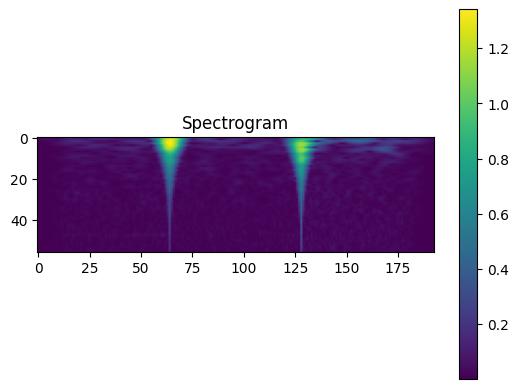

In [58]:
#the id is in train_labels, use the id fromit to find the path of each training data
Spectrogram=increase_dimension(train_labels["id"][0], is_train = True)
# spectrogram created for the first id
#ax4 = fig.add_subplot(gs[i*2, 3])
plt.imshow(Spectrogram)
plt.colorbar()
plt.title("Spectrogram")
#ax4.set_axis_off()

# Visualize the data

In [13]:
#the IDs for the detected Gravitational Wave (GW) event
targets = train_labels[train_labels["target"] == 0]["id"].head()
#the IDs with no Gravitational Wave (GW) event detected
no_targets = train_labels[train_labels["target"] == 1]["id"].head()
print(targets)

1     00001f4945
2     0000661522
3     00007a006a
6     0000c3b9c9
10    000118b40d
Name: id, dtype: object


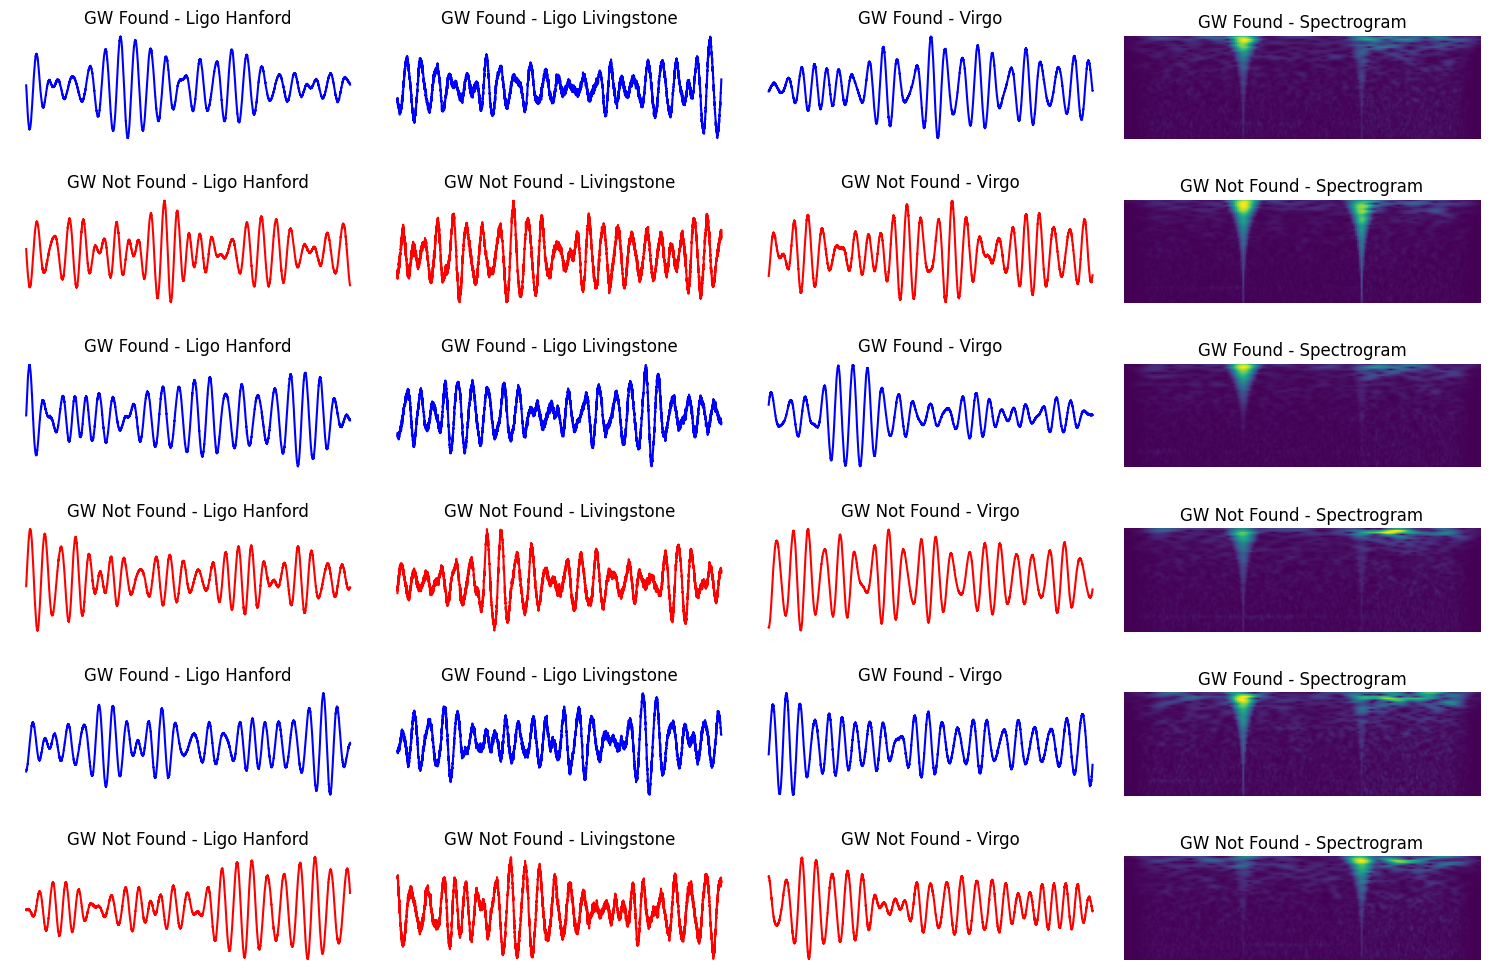

In [69]:
targets = train_labels[train_labels["target"] == 0]["id"].head(3)
no_targets = train_labels[train_labels["target"] == 1]["id"].head(3)
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(6, 4, figure=fig)

for i, (target, no_target) in enumerate(zip(targets, no_targets)):
    # Subplot para GW Found (gráfico de líneas)
    ax1 = fig.add_subplot(gs[i*2, 0])
    ax1.plot(np.load(id2path(target))[1, :], color='blue')
    ax1.set_title("GW Found - Ligo Hanford")
    ax1.set_axis_off()

    ax2 = fig.add_subplot(gs[i*2, 1])
    ax2.plot(np.load(id2path(target))[2, :], color='blue')
    ax2.set_title("GW Found - Ligo Livingstone")
    ax2.set_axis_off()

    ax3 = fig.add_subplot(gs[i*2, 2])
    ax3.plot(np.load(id2path(target))[0, :], color='blue')
    ax3.set_title("GW Found - Virgo")
    ax3.set_axis_off()

    ax4 = fig.add_subplot(gs[i*2, 3])
    ax4.imshow(increase_dimension(target, is_train=True))
    ax4.set_title("GW Found - Spectrogram")
    ax4.set_axis_off()


    # Subplot para GW Not Found (gráfico de líneas)
    ax5 = fig.add_subplot(gs[i*2 + 1, 0])
    ax5.plot(np.load(id2path(no_target))[1, :], color='red')
    ax5.set_title("GW Not Found - Ligo Hanford")
    ax5.set_axis_off()

    ax6 = fig.add_subplot(gs[i*2 + 1, 1])
    ax6.plot(np.load(id2path(no_target))[2, :], color='red')
    ax6.set_title("GW Not Found - Livingstone")
    ax6.set_axis_off()

    ax7 = fig.add_subplot(gs[i*2 + 1, 2])
    ax7.plot(np.load(id2path(no_target))[0, :], color='red')
    ax7.set_title("GW Not Found - Virgo")
    ax7.set_axis_off()

    ax8 = fig.add_subplot(gs[i*2 + 1, 3])
    ax8.imshow(increase_dimension(no_target, is_train=True))
    ax8.set_title("GW Not Found - Spectrogram")
    ax8.set_axis_off()

plt.tight_layout()
plt.show()



# Batch Data

In [70]:
import math
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, data, y = None, batch_size = 256, shuffle = True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle

        if y is not None:
            self.is_train = True
        else:
            self.is_train = False

        self.y = y

    def __len__(self):
        return math.ceil(len(self.data)/ self.batch_size)

    def __getitem__(self, ids):
        batch_data = self.data[ids * self.batch_size : (ids + 1) * self.batch_size]

        if self.y is not None:
            batch_y = self.y[ids * self.batch_size : (ids + 1) * self.batch_size]

        batch_x = np.array([increase_dimension(x, self.is_train) for x in batch_data])
        batch_x = np.stack(batch_x)

        if self.is_train:
            return batch_x, batch_y
        else:
            return batch_x

    def on_epoch_end(self):
        if self.shuffle and self.is_train:
            ids_y = list(zip(self.data, self.y))
            shuffle(ids_y)
            self.data, self.y = list(zip(*ids_y))



In [79]:
train_idx =  train_labels['id'].values
y = train_labels['target'].values
test_idx = sample_submission['id'].values

x_train,x_valid,y_train,y_valid = train_test_split(train_idx,y,test_size=0.05,random_state=42,stratify=y)

#divide data in batches
train_dataset = Dataset(x_train,y_train)
valid_dataset = Dataset(x_valid,y_valid)
test_dataset = Dataset(test_idx)

In [72]:
pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00


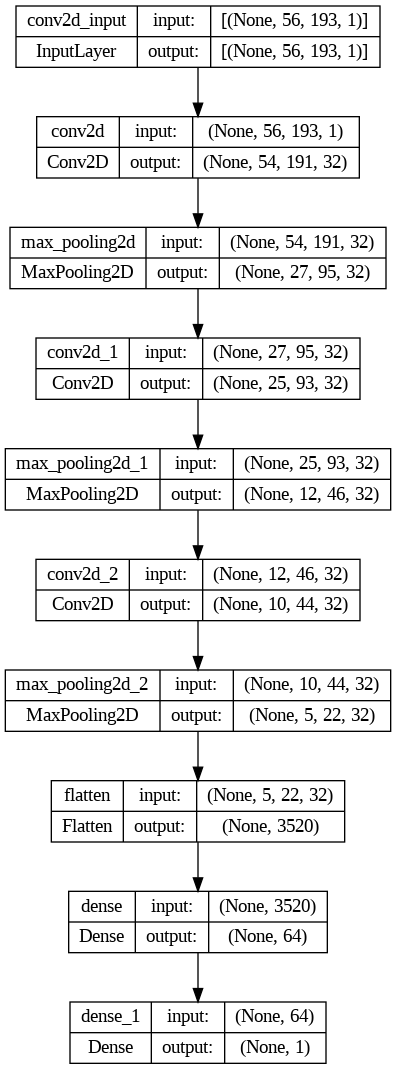

In [73]:
def create_model():
    Conv1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3) ,input_shape = [56, 193, 1], activation = "elu")
    Maxpooling1 = tf.keras.layers.MaxPool2D()
    Conv2 = tf.keras.layers.Conv2D(filters = 32,  kernel_size = (3, 3), activation = "elu")
    Maxpooling2 = tf.keras.layers.MaxPool2D()
    Conv3 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = "elu")
    Maxpooling3 = tf.keras.layers.MaxPool2D()
    flatten = tf.keras.layers.Flatten()
    Dense1 = tf.keras.layers.Dense(64, activation = "relu")
    dense2 = tf.keras.layers.Dense(1, activation = "sigmoid")

    model = tf.keras.Sequential([Conv1, Maxpooling1,Conv2, Maxpooling2, Conv3, Maxpooling3, flatten ,Dense1, dense2])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

    return model

model = create_model()

from tensorflow.keras.utils import plot_model

# Definir el modelo aquí (igual que en el código anterior)

# Crear un objeto TensorBoard para visualizar el modelo
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Entrenar el modelo con el objeto TensorBoard como argumento de callback
# model.fit(x_train, y_train, epochs=10, callbacks=[tensorboard_callback])

# Generar una imagen del diagrama de flujo del modelo
plot_model(model, to_file='model.png', show_shapes=True)



In [74]:
model.fit(train_dataset, epochs = 2, validation_data = valid_dataset)

Epoch 1/2
9/9 [==============================] - 43s 4s/step - loss: 0.6953 - auc: 0.4884 - val_loss: 0.6900 - val_auc: 0.6323
Epoch 2/2
9/9 [==============================] - 39s 4s/step - loss: 0.6904 - auc: 0.5594 - val_loss: 0.6777 - val_auc: 0.6722


In [87]:
preds = model.predict(valid_dataset)
preds = preds.reshape(-1)
#print(preds)
print(valid_dataset[0])

1/1 [==============================] - 1s 1s/step
(array([[[[6.69464990e-02],
         [6.88830391e-02],
         [7.43899271e-02],
         ...,
         [1.98321730e-01],
         [1.79686934e-01],
         [1.73033580e-01]],

        [[4.54674214e-02],
         [4.54550758e-02],
         [4.60345261e-02],
         ...,
         [1.77188218e-01],
         [1.20013274e-01],
         [9.41300839e-02]],

        [[8.92662629e-03],
         [9.63020045e-03],
         [1.08789383e-02],
         ...,
         [1.59132451e-01],
         [1.02639541e-01],
         [7.67905116e-02]],

        ...,

        [[1.51512813e-05],
         [3.42330401e-04],
         [7.95592030e-04],
         ...,
         [4.60457872e-04],
         [2.72000296e-04],
         [3.31645424e-05]],

        [[2.78877474e-06],
         [4.27058461e-04],
         [2.96894461e-04],
         ...,
         [1.57977827e-03],
         [1.90536652e-04],
         [4.37755671e-06]],

        [[2.38910106e-05],
         [3.407220

In [89]:
preds = model.predict(test_dataset)
preds = preds.reshape(-1)
submission = pd.DataFrame({'id':sample_submission['id'],'target':preds})
submission.to_csv('submission.csv',index=False)
submission.head(10)

4/4 [==============================] - 11s 2s/step


,id,target
0,00005bced6,0.473878
1,0000806717,0.462044
2,0000ef4fe1,0.456067
3,00020de251,0.461193
4,00024887b5,0.476093
5,0002b00931,0.479476
6,0003259f74,0.499575
7,000532d9b1,0.553615
8,00053de60c,0.492605
9,00055a3ff5,0.480312
